- From BACCH paper: In this form, $z$ is defined as $z = e^{i2\omega\tau_c}$, where $\tau_c$ is a time delay expressed in microseconds (µs), 
- This represents a complex exponential corresponding to a $\tau_c$ delay in frequency domain. 
- This is a symbolic algebraic representation used for analytical manipulation in the paper.

$$
\begin{align}
H_\rm{ipsi} 
&= \frac{z^2g^2-z(\beta+1)}{z^2g^2+g^2-z[(g^2+\beta)^2+2\beta+1]} \\
&= \frac{g^2-(\beta+1)z^{-1}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
\end{align}
$$

$$
\begin{align}
H_\rm{cont} 
&= \frac{z[gz^{-0.5}-g(g^2+\beta)z^{0.5}]}{z^2g^2+g^2-z[(g^2+\beta)^2+2\beta+1]} \\
&= \frac{z^{-1}[gz^{-0.5}-g(g^2+\beta)z^{0.5}]}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
&= \frac{[gz^{-1.5}-g(g^2+\beta)z^{-0.5}]}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
&= \frac{-g(g^2+\beta)z^{-0.5}+gz^{-1.5}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
\end{align}
$$

- Now: reformulated using $\tau$ as number of delay samples, and expressing each term using $z^{-n}$, for actual DSP implementation.
- Here, $z^{-1}$ corresponds to one sample delay, so $z^{-2\tau}$ = delay by $2\tau$ samples (because BACCH uses a $2\tau_c$ delay as base unit)

$$
\begin{align}
H_\rm{ipsi} 
&= \frac{g^2-(\beta+1)z^{-2\tau}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-2\tau}+g^2z^{-4\tau}}\\
\end{align}
$$

$$
\begin{align}
H_\rm{cont} 
&= \frac{-g(g^2+\beta)z^{-\tau}+gz^{-3\tau}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-2\tau}+g^2z^{-4\tau}}\\
\end{align}
$$

$$
\begin{align}
H_{\rm{ipsi}} 
&= \frac{z^2g^2\bar{h^2}-z(\beta+1)}{z^2g^2\bar{h}^2+g^2h^2-z((g^2h\bar{h}+\beta)^2+2\beta+1)}\\
&= \frac{g^2\bar{h^2}-(\beta+1)z^{-1}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-1}+g^2h^2z^{-2}}\\
H_{\rm{cont}} 
&= \frac{z[ghz^{-0.5}-(g^2h\bar{h}+\beta)g\bar{h}z^{0.5}]}{z^2g^2\bar{h}^2+g^2h^2-z((g^2h\bar{h}+\beta)^2+2\beta+1)}\\
&= \frac{-(g^2h\bar{h}+\beta)g\bar{h}z^{-0.5}+ghz^{-1.5}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-1}+g^2h^2z^{-2}}\\
\end{align}
$$

$$
\begin{align}
H_{\rm{ipsi-hs}} 
&= \frac{g^2\bar{h^2}z^{2\tau}-(\beta+1)}{(1+g^2h\bar{h}+\beta)^2-(ghz^{-\tau}+g\bar{h}z^{\tau})^2}\frac{z^{-2\tau}}{z^{-2\tau}}\\
&= \frac{g^2\bar{h^2}-(\beta+1)z^{-2\tau}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-2\tau}+g^2h^2z^{-4\tau}}\\
H_{\rm{cont-hs}} 
&= \frac{-(g^2h\bar{h}+\beta)g\bar{h}z^{\tau}+ghz^{-\tau}}{(1+g^2h\bar{h}+\beta)^2-(ghz^{-\tau}+g\bar{h}z^{\tau})^2}\frac{z^{-2\tau}}{z^{-2\tau}}\\
&= \frac{-(g^2h\bar{h}+\beta)g\bar{h}z^{-\tau}+ghz^{-3\tau}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-2\tau}+g^2h^2z^{-4\tau}}\\
\end{align}
$$

In [1]:
from sympy import symbols, print_latex, simplify, fraction, latex, expand, collect, Poly, pprint
from IPython.display import display, Markdown

z, a0, a1, b0, b1, g, tau, beta, D, N, d, n = symbols('z a_0 a_1 b_0 b_1 g tau B D N d n')

h = (N/D)
hr = (n/d)

h_x_h = (h*h)
h_x_hr = (h*hr)
hr_x_hr = (hr*hr)

display(Markdown(rf"$$AA={latex(h_x_h)}$$"))
display(Markdown(rf"$$AB={latex(h_x_hr)}$$"))
display(Markdown(rf"$$BB={latex(hr_x_hr)}$$"))

numerator_ipsi = (g**2 * hr_x_hr - (beta + 1)*z**(-2*tau))*D*D*d*d
numerator_ipsi = simplify(numerator_ipsi)

numerator_cont = ( -(g**2*h_x_hr+beta)*g*hr*z**(-1*tau) + g*h*z**(-3*tau) ) *D*D*d*d
numerator_cont = simplify(numerator_cont)

denominator = (g**2 * hr_x_hr - (((g**2 * h_x_hr + beta)**2 + 2*beta + 1)*z**(-2*tau)) + (g**2 * h_x_h * z**(-4*tau)))*D*D*d*d
denominator = simplify(denominator)

display(Markdown(rf"$$\mathrm{{Num_{{ipsi}}}} =   {latex(numerator_ipsi)}$$"))
display(Markdown(rf"$$\mathrm{{Num_{{cont}}}} =   {latex(numerator_cont)}$$"))
display(Markdown(rf"$$\mathrm{{Den_{{shared}}}} = {latex(denominator)}$$"))

$$AA=\frac{N^{2}}{D^{2}}$$

$$AB=\frac{N n}{D d}$$

$$BB=\frac{n^{2}}{d^{2}}$$

$$\mathrm{Num_{ipsi}} =   D^{2} z^{- 2 \tau} \left(- d^{2} \left(B + 1\right) + g^{2} n^{2} z^{2 \tau}\right)$$

$$\mathrm{Num_{cont}} =   D g z^{- 3 \tau} \left(N d^{2} - n z^{2 \tau} \left(B D d + N g^{2} n\right)\right)$$

$$\mathrm{Den_{shared}} = z^{- 4 \tau} \left(D^{2} g^{2} n^{2} z^{4 \tau} + N^{2} d^{2} g^{2} - z^{2 \tau} \left(D^{2} d^{2} \cdot \left(2 B + 1\right) + \left(B D d + N g^{2} n\right)^{2}\right)\right)$$

$$
\begin{align}
{\rm{Num}_{ipsi}} &= g^2(DDnn) - (\beta+1)(DDdd)z^{-2\tau}\\
{\rm{Num}_{cont}} &= -g^3(DNnn)z^{-\tau}-\beta(DDdn)z^{-\tau} + g(DddN)z^{-3\tau} \\
{\rm{Den}_{shared}} &= g^2(DDnn) - g^4(NNnn)z^{-2\tau} - 2 \beta g^2 (DdNn)z^{-2\tau} - (\beta+1)^2(DDdd)z^{-2\tau} + g^2(NNdd)z^{-4\tau}\\
\end{align}
$$

$$
\begin{align}
     h  &= \frac{b_0 + b_1z^{-1}}{a_0 + a_1z^{-1}}\\
\bar{h} &= \frac{b_1 + b_0z^{-1}}{a_1 + a_0z^{-1}}\\
\end{align}
$$

$$
\begin{align}
hh 
&= \frac{b_0^2 + 2b_0b_1z^{-1}+b_1^2z^{-2}}{a_0^2 + 2a_0a_1z^{-1}+a_1^2z^{-2}}\\
\bar{h}\bar{h} 
&= \frac{b_1^2 + 2b_0b_1z^{-1}+b_0^2z^{-2}}{a_1^2 + 2a_0a_1z^{-1}+a_0^2z^{-2}}\\
\bar{h}h 
&= \frac{b_0b_1+(b_0^2+b_1^2)z^{-1}+b_0b_1z^{-2}}{a_0a_1+(b_0^2+b_1^2)z^{-1}+a_0a_1z^{-2}}\\
\bar{h}^2h^2 
&= \frac{
(b_0 b_1)^2 + 2b_0 b_1 (b_0^2 + b_1^2) z^{-1} + \left[(b_0^2 + b_1^2)^2 + 2(b_0 b_1)^2\right] z^{-2} + 2b_0 b_1 (b_0^2 + b_1^2) z^{-3} + (b_0 b_1)^2 z^{-4}
}{
(a_0 a_1)^2 + 2a_0 a_1 (b_0^2 + b_1^2) z^{-1} + \left[(b_0^2 + b_1^2)^2 + 2(a_0 a_1)^2\right] z^{-2} + 2a_0 a_1 (b_0^2 + b_1^2) z^{-3} + (a_0 a_1)^2 z^{-4}
}
\end{align}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
g = 0.985
beta = 0.05
tau = 3  # e.g., 3 samples ≈ 68us @ 44.1kHz
sample_rate = 44100

In [4]:
def generate_filter_coeffs(g, beta, tau):
    N = 4 * tau + 1  # total length required
    
    # --- Ipsi numerator ---
    b_ipsi = np.zeros(N)
    b_ipsi[0] = g**2
    b_ipsi[2 * tau] = -(beta + 1)

    # --- Cont numerator ---
    b_cont = np.zeros(N)
    b_cont[tau] = -g * (g**2 + beta)
    b_cont[3 * tau] = g

    # --- Shared denominator ---
    a = np.zeros(N)
    a[0] = g**2
    a[2 * tau] = -((g**2 + beta)**2 + 2 * beta + 1)
    a[4 * tau] = g**2

    return b_ipsi, b_cont, a

def analysis_cancellation(b_ipsi, b_cont, a, g, tau):
    """
    Compute and plot the crosstalk cancellation spectrum
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - g: gain parameter
    - tau: delay in samples
    """
    # Compute frequency response of each filter
    w, H_ipsi = signal.freqz(b_ipsi, a)
    w, H_cont = signal.freqz(b_cont, a)

    # Apply g and delay logic directly (in frequency domain)
    # delay = e^{-iωτ}, so we use exp(-1j * w * tau)
    delay = np.exp(-1j * w * tau)
    Compensate = H_ipsi + g * H_cont * delay
    Cancel = H_cont + g * H_ipsi * delay

    # Compute cancellation metric
    cancellation = np.abs(Compensate) / np.abs(Cancel)

    # Plot
    plt.title('Crosstalk Cancellation Spectrum')
    plt.plot(w, 20 * np.log10(cancellation), label="XTC Cancellation")
    plt.legend()
    plt.grid()
    plt.ylim(-48, 60)
    plt.xlabel("Radian Frequency (Ω)")
    plt.ylabel("Amplitude (dB)")
    plt.show()
    
def analysis_coloration(b_ipsi, b_cont, a, sample_rate):
    """
    Analyze coloration introduced by crosstalk cancellation filters
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - sample_rate: sampling rate in Hz
    """
    w, h_ipsi = signal.freqz(b_ipsi, a, fs=sample_rate)
    w, h_cont = signal.freqz(b_cont, a, fs=sample_rate)

    si = np.abs(h_ipsi + h_cont)
    so = np.abs(h_ipsi - h_cont)

    plt.title('Crosstalk Cancellation Filter Coloration Spectrum')
    plt.plot(w, 20 * np.log10(np.maximum(si, so)), label='Max(|L+R|, |L−R|)')
    plt.ylim(-30, 12)
    plt.legend()
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.show()

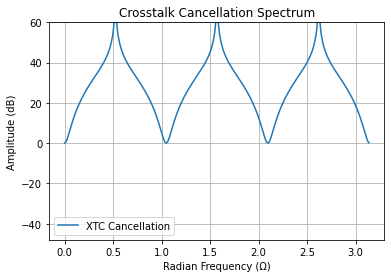

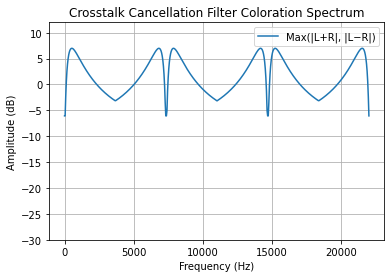

In [5]:
b_ipsi, b_cont, a = generate_filter_coeffs(g, beta, tau)
analysis_cancellation(b_ipsi, b_cont, a, g, tau)
analysis_coloration(b_ipsi, b_cont, a, sample_rate)

In [6]:
g = 0.985
beta = 0.05
tau = 3  # e.g., 3 samples ≈ 68us @ 44.1kHz
sample_rate = 44100

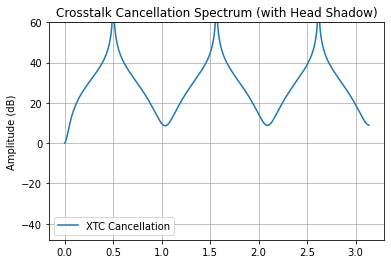

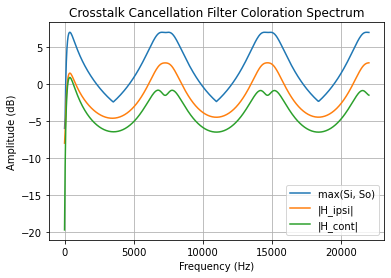

In [7]:
def convolve_all(*args):
    out = args[0]
    for a in args[1:]:
        out = np.convolve(out, a)
    return out
    
def generate_hs_filter_coeffs(g, beta, tau, N, D):
    offset = 5 # order of cascade 1st order filter for 4 times!
    size = 4 * tau + offset  # total length required

    # conjugate
    n = N[::-1]
    d = D[::-1]

    b_ipsi = np.zeros(size)
    b_cont = np.zeros(size)
    a = np.zeros(size)
    
    # --- Ipsi numerator ---
    b_ipsi[0:offset] += g**2 * convolve_all(D, D, n, n) 
    b_ipsi[2*tau:2*tau+offset] += -(beta + 1) * convolve_all(D, D, d, d)

    # --- Cont numerator ---
    b_cont[tau:tau+offset] += -g**3 * convolve_all(D, N, n, n)
    b_cont[tau:tau+offset] += -beta * convolve_all(D, D, d, n)
    b_cont[3*tau:3*tau+offset] += g * convolve_all(D, d, d, N)

    # --- Shared denominator ---
    a[0:offset] += g**2 * convolve_all(D, D, n, n) 
    a[2*tau:2*tau+offset] += -g**4 * convolve_all(N, N, n, n)
    a[2*tau:2*tau+offset] += -2 * beta * g * g * convolve_all(D, d, N, n)
    a[2*tau:2*tau+offset] += -(beta+1)**2 * convolve_all(D, D, d, d)
    a[4*tau:4*tau+offset] += g**2 * convolve_all(N, N, d, d)

    return b_ipsi, b_cont, a

def analysis_cancellation(b_ipsi, b_cont, a, Num, Den, g, tau):
    """
    Compute and plot the crosstalk cancellation spectrum
    using IIR filter coefficients and a head shadow model.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: shared denominator coefficients
    - b_h: numerator of head shadow filter
    - a_h: denominator of head shadow filter
    - g: gain parameter
    - tau: delay in samples
    - fs: sample rate (or 2π for radian freq)
    """
    # Frequency response of filter
    w, H_ipsi = signal.freqz(b_ipsi, a)
    _, H_cont = signal.freqz(b_cont, a)

    # Frequency response of head shadow filter
    _, H_hs = signal.freqz(Num, Den)

    # Total contralateral path: g * h(ω) * e^{-iωτ}
    acoustic_path = g * H_hs * np.exp(-1j * w * tau)

    # Reconstruct signals
    Compensate = H_ipsi + acoustic_path * H_cont
    Cancel     = H_cont + acoustic_path * H_ipsi

    # Compute cancellation metric
    cancellation = np.abs(Compensate) / np.abs(Cancel)
    
    # Plot
    plt.title('Crosstalk Cancellation Spectrum (with Head Shadow)')
    plt.plot(w, 20 * np.log10(cancellation), label="XTC Cancellation")
    plt.legend()
    plt.grid()
    plt.ylim(-48, 60)
    plt.ylabel("Amplitude (dB)")
    plt.show()

def analysis_coloration(b_ipsi, b_cont, a, sample_rate):
    """
    Analyze coloration introduced by crosstalk cancellation filters
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - sample_rate: sampling rate in Hz
    """
    w, h_ipsi = signal.freqz(b_ipsi, a, fs=sample_rate)
    w, h_cont = signal.freqz(b_cont, a, fs=sample_rate)

    si = np.abs(h_ipsi + h_cont)
    so = np.abs(h_ipsi - h_cont)

    plt.title('Crosstalk Cancellation Filter Coloration Spectrum')
    plt.plot(w, 20 * np.log10(np.maximum(si, so)), label='max(Si, So)')
    plt.plot(w, 20 * np.log10(np.abs(h_ipsi)), label='|H_ipsi|')
    plt.plot(w, 20 * np.log10(np.abs(h_cont)), label='|H_cont|')
    # plt.ylim(-30, 12)
    plt.legend()
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.show()

# cont: [0.6096938775510208, -0.44642857142857173] [1, -0.8367346938775511]
# ipsi: [1.4821428571428572, -1.3188775510204085] [1, -0.8367346938775511]
# cont = [1.0, 0.0] 
# ipsi = [1.0, 0.0]
cont = [0.9411051048942621, -0.7778397987718131] 
ipsi = [1.150731629799616, -0.987466323677167]
Num = cont
Den = ipsi
# Num = [1.0, 0.0]
# Den = [1.0, 0.0]

b_ipsi, b_cont, a = generate_hs_filter_coeffs(g, beta, tau, Num, Den)
analysis_cancellation(b_ipsi, b_cont, a, Num, Den, g, tau)
analysis_coloration(b_ipsi, b_cont, a, sample_rate)

$$
\begin{align}
H_{\rm{den-hs}} 
&= \frac{1}{(1+g^2h\bar{h}+\beta)^2-(ghz^{-\tau}+g\bar{h}z^{\tau})^2}\frac{z^{-2\tau}}{z^{-2\tau}} \\
&= \frac{1}{(1+g^2h\bar{h}+\beta-ghz^{-\tau}-g\bar{h}z^{\tau})(1+g^2h\bar{h}+\beta+ghz^{-\tau}+g\bar{h}z^{\tau})}\frac{z^{-2\tau}}{z^{-2\tau}} \\
\end{align}
$$

$$
\begin{align}
h = &\frac{N}{D} = \frac{b_0+b_1z^{-1}}{a_0+a_1z^{-1}}\\
\bar{h} = &\frac{n}{d} = \frac{b_1+b_0z^{-1}}{a_1+a_0z^{-1}} \\
\end{align}
$$

$$
\begin{align}
H_{\rm{den-hs}}  
&= \frac{1}{(1+g^2\frac{N}{D}\frac{n}{d}+\beta-g\frac{N}{D}z^{-\tau}-g\frac{n}{d}z^{\tau})(1+g^2\frac{N}{D}\frac{n}{d}+\beta+g\frac{N}{D}z^{-\tau}+g\frac{n}{d}z^{\tau})}\frac{z^{-2\tau}}{z^{-2\tau}} \\
&= \frac{DDdd}{(Dd+g^2Nn+\beta Dd-gNdz^{-\tau}-gnDz^{\tau})(Dd+g^2Nn+\beta Dd+gNdz^{-\tau}+gnDz^{\tau})}\frac{z^{-2\tau}}{z^{-2\tau}} \\
&= \frac{DDdd z^{-2\tau}}{(Ddz^{-\tau}+g^2Nnz^{-\tau}+\beta Dd z^{-\tau} -gNdz^{-2\tau}-gnD)(Ddz^{-\tau}+g^2Nnz^{-\tau}+\beta Dd z^{-\tau} + gNdz^{-2\tau}+gnD)} \\
\end{align}
$$

In [8]:
# Define variables
z, a0, a1, b0, b1 = symbols('z a_0 a_1 b_0 b_1')
zinv = z**(-1)

# Define polynomials
D = a0 + a1 * zinv
d = a1 + a0 * zinv
N = b0 + b1 * zinv
n = b1 + b0 * zinv

# Define polynomial multiplication results
Dd = expand(D * d)
Nn = expand(N * n)
Nd = expand(N * d)
nD = expand(n * D)

# Display function (LaTeX + coefficient array)
def display_poly(expr, name):
    poly = Poly(expr, zinv)
    terms = poly.terms()
    parts = []
    coeff_list = [0] * (poly.degree() + 1)  # Preallocate coefficient list
    
    for exp, coeff in terms:
        if exp[0] == 0:
            parts.append(f"{latex(coeff)}")
        else:
            parts.append(f"({latex(coeff)})z^{{-{exp[0]}}}")
        coeff_list[exp[0]] = coeff  # Directly assign to corresponding position
    
    expr_str = " + ".join(parts)
    display(Markdown(rf"$${name} = {expr_str}$$"))

# Display all four results
display_poly(Dd, "Dd")
display_poly(Nn, "Nn")
display_poly(Nd, "Nd")
display_poly(nD, "nD")

$$Dd = (a_{0} a_{1})z^{-2} + (a_{0}^{2} + a_{1}^{2})z^{-1} + a_{0} a_{1}$$

$$Nn = (b_{0} b_{1})z^{-2} + (b_{0}^{2} + b_{1}^{2})z^{-1} + b_{0} b_{1}$$

$$Nd = (a_{0} b_{1})z^{-2} + (a_{0} b_{0} + a_{1} b_{1})z^{-1} + a_{1} b_{0}$$

$$nD = (a_{1} b_{0})z^{-2} + (a_{0} b_{0} + a_{1} b_{1})z^{-1} + a_{0} b_{1}$$

Decompose the denominator into two factors:

$$
\begin{align}
{\rm{term_1}}{\rm{term_2}}
&= \frac{1}{\square^2-\lozenge^2} \\
&= \frac{1}{(\square-\lozenge)(\square+\lozenge)} \\
&= \frac{1}{(1+g^2h\bar{h}+\beta-ghz^{-\tau}-g\bar{h}z^{\tau})(1+g^2h\bar{h}+\beta+ghz^{-\tau}+g\bar{h}z^{\tau})}\frac{1}{z^{-\tau}}\frac{1}{z^{-\tau}} \\
&= \frac{1}{(Ddz^{-\tau}+g^2Nnz^{-\tau}+\beta Dd z^{-\tau} -gNdz^{-2\tau}-gnD)(Ddz^{-\tau}+g^2Nnz^{-\tau}+\beta Dd z^{-\tau} + gNdz^{-2\tau}+gnD)} \\
\end{align}
$$

Define headshadow-related polynomial coefficients:

$$
\begin{align}
B(z) = [B_2 + B_1z^{-1} + B_0z^{-2}] &= g(n \cdot D) \\
A(z) = [A_0 + A_1z^{-1} + A_0z^{-2}] &= (D \cdot d)+g(N \cdot n)+\beta (D \cdot d) \\
\bar{B}(z) = [B_0 + B_1z^{-1} + B_2z^{-2}] &= g(N \cdot d) \\
\end{align}
$$

Reorganize the two denominator terms using these polynomials:

$$
\begin{align}
{\rm{term_1}} 
&=
-B(z)+A(z)z^{-\tau}-\bar{B}(z)z^{-2\tau}\\
&=
-(B_2+B_1z^{-1}+B_0z^{-2})
+(A_0+A_1z^{-1}+A_0z^{-2})z^{-\tau}  
-(B_0+B_1z^{-1}+B_2z^{-2})z^{-2\tau} \\
{\rm{term_2}} 
&=
+B(z)+A(z)z^{-\tau}+\bar{B}(z)z^{-2\tau}\\
&=
+(B_2+B_1z^{-1}+B_0z^{-2})
+(A_0+A_1z^{-1}+A_0z^{-2})z^{-\tau}  
+(B_0+B_1z^{-1}+B_2z^{-2})z^{-2\tau} 
\end{align}
$$

$$
\begin{align}
b &= -((g^2h\bar{h}+\beta)^2+2\beta+1)\\
b1, b2 &= \frac{b\pm\sqrt{b^2-4g^4h^2\bar{h}^2}}{2g^2\bar{h}^2}
\end{align}
$$


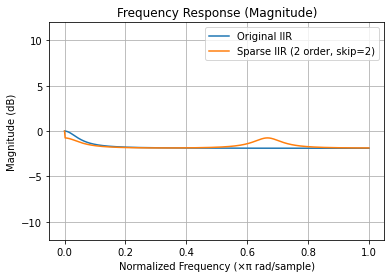

In [9]:
import numpy as np
from scipy.signal import freqz
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Target IIR filter to approximate
b_orig = [0.9411051048942621, -0.7778397987718131] 
a_orig = [1.150731629799616, -0.987466323677167]

# Frequency sampling points
w = np.linspace(0, np.pi, 512)
_, H_target = freqz(b_orig, a_orig, worN=w)

def sparse_iir_response(params, w, num_order, skip):
    """
    Generate frequency response of a sparse-structured IIR filter
    with fixed numerator a[0] = 1.0.

    Parameters:
    - params: [a1, a2, ..., b0, b1, ...], total of 2*num_order - 1 coefficients
    - w: frequency points (in rad/sample)
    - num_order: total number of non-zero coefficients (including fixed a[0])
    - skip: number of zeros to insert between coefficients (sparse interval)

    Returns:
    - H: complex frequency response
    """
    assert len(params) == 2 * num_order - 1, "params must contain (num_order - 1) numerator and num_order denominator coefficients"

    filter_len = (num_order - 1) * (skip + 1) + 1
    a = np.zeros(filter_len)
    b = np.zeros(filter_len)

    # Insert numerator coefficients: first value is fixed to 1.0, followed by params
    a[::skip + 1] = np.concatenate(([1.0], params[:num_order - 1]))

    # Insert denominator coefficients: taken from the remaining params
    b[::skip + 1] = params[num_order - 1:]
    
    _, H = freqz(a, b, worN=w)
    return H

w = np.linspace(0, np.pi, 512)
_, H_target = freqz(b_orig, a_orig, worN=w)

# Sparse filter configuration
num_order = 3    # Total number of taps (including a[0])
skip = 2         # Insert one non-zero coefficient every (skip + 1) samples

# Initial guess for parameters
x0 = np.random.rand(2 * num_order - 1) * 0.2

def loss(params):
    H_current = sparse_iir_response(params, w, num_order=num_order, skip=skip)
    amp_current = np.abs(H_current)
    amp_target = np.abs(H_target)
    err = (amp_current - amp_target) / (amp_target + 1e-9)
    weight = 1.0 - 0.8 * (w / np.pi)  # from 1.0 (low freq) to 0.2 (high freq)
    return err * weight

# Least squares fitting
res = least_squares(loss, x0)

# Evaluate the resulting sparse filter
H_sparse = sparse_iir_response(res.x, w, num_order, skip)

# Plot comparison
plt.plot(w / np.pi, 20 * np.log10(np.abs(H_target)), label='Original IIR')
plt.plot(w / np.pi, 20 * np.log10(np.abs(H_sparse)), label=f'Sparse IIR ({num_order-1} order, skip={skip})')
plt.title('Frequency Response (Magnitude)')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
plt.show()

shared denominator:
  [  0.77732186  -3.21502846   4.93845308  -3.33795927   0.83790215
   0.          -2.00868035   8.14307633 -12.27031307   8.14307633
  -2.00868035   0.           0.83790215  -3.33795927   4.93845308
  -3.21502846   0.77732186]


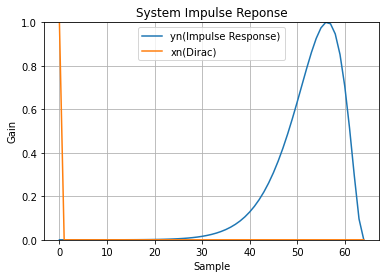

In [10]:
print("shared denominator:\n ", a)

# length = 129
# xn = np.zeros(length)
# center_index = (length - 1)//2
# xn[center_index] = 1.0
# w = np.hanning(2*length)[:length]

# create dirac function
length = 65
xn = np.zeros(length)
xn[0] = 1

w = np.hanning(2*length)[:length]
w = w[::-1]

# Apply Hann Window
yn = signal.lfilter([1], a, xn) * w
peak = np.abs(np.max(yn))

# normalization IR 
yn_norm = yn / peak

plt.title('System Impulse Reponse')
plt.plot(yn_norm, label = "yn(Impulse Response)")
plt.plot(xn, label = "xn(Dirac)" )
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.xlabel("Sample")
plt.ylabel("Gain")
plt.show()

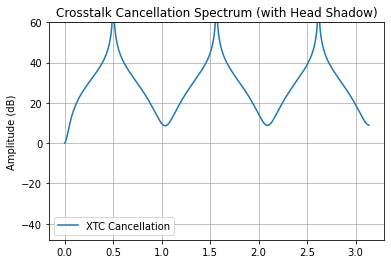

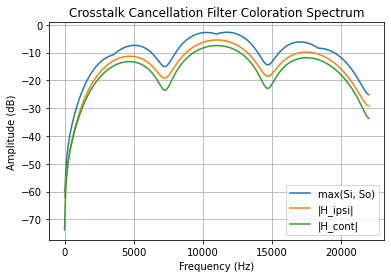

In [11]:
# convolve denomiator and numerator
b_ipsi_ = np.convolve(yn_norm, b_ipsi)
b_cont_ = np.convolve(yn_norm, b_cont)

analysis_cancellation(b_ipsi_, b_cont_, [1], Num, Den, g, tau)
analysis_coloration(b_ipsi_, b_cont_, [1], sample_rate)